## 导入库

In [1]:
# -*- coding: utf-8 -*-
from __future__ import annotations

# ── 标准库 ──────────────────────────────────────────────────────────────────
import os
import time
from pathlib import Path
from collections import defaultdict
from datetime import datetime

# ── 第三方 ──────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import polars as pl

import torch
import torch.backends.cudnn as cudnn
import lightning as L
import lightning.pytorch as lp
from torch.utils.data import DataLoader

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import DeviceStatsMonitor
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.metrics import MAE, RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.data import TorchNormalizer, GroupNormalizer


# 你的工程工具
from pipeline.io import cfg, P, fs, storage_options, ensure_dir_local
from pipeline.stream_input_local import ShardedBatchStream  # 使用下方给你的新版类
from pipeline.wr2 import WR2

# ---- 性能/兼容开关（仅一次）----
os.environ.setdefault("POLARS_MAX_THREADS", str(max(1, os.cpu_count() // 2)))
pl.enable_string_cache()
cudnn.benchmark = True
torch.set_float32_matmul_precision("high")

import time as _t


import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

def _now() -> str:
    return _t.strftime("%Y-%m-%d %H:%M:%S")
print(f"[{_now()}] imports ok")

[2025-10-13 10:28:15] imports ok


## 定义工具函数

In [2]:
# ───────────────────────────────────────────────────────────────────────────
# 滑动窗划分
def make_sliding_cv_by_days(all_days: np.ndarray, *, n_splits: int, gap_days: int, train_to_val: int):
    all_days = np.asarray(all_days).ravel()
    K, R, G = n_splits, train_to_val, gap_days
    usable = len(all_days) - G
    if usable <= 0 or K <= 0 or R <= 0:
        return []
    V_base, rem = divmod(usable, R + K)
    if V_base <= 0:
        return []
    T = R * V_base
    v_lens = [V_base + 1 if i < rem else V_base for i in range(K)]
    folds, v_lo = [], T + G
    for V_i in v_lens:
        v_hi, tr_hi, tr_lo = v_lo + V_i, v_lo - G, v_lo - G - T
        if tr_lo < 0 or v_hi > len(all_days):
            break
        folds.append((all_days[tr_lo:tr_hi], all_days[v_lo:v_hi]))
        v_lo = v_hi
    return folds


## 初始化参数

In [3]:
# 读入筛选的特征列
df_ranking_features = pd.read_csv("/mnt/data/js/exp/v1/models/tune/feature_importance__fixed__fixed__mm_full_train__features__fs__1300-1500__cv3-g7-r4__seed42__top1000__1760299442__range1000-1600__range1000-1600__cv2-g7-r4__1760347190.csv")
ls_topk_features = df_ranking_features['feature'].tolist()[:600]
TIME_FEATURES = ["time_bucket", "time_pos", "time_sin", "time_cos"]
TO_Z_INPUTS = [c for c in ls_topk_features if c not in TIME_FEATURES]

In [ ]:
# ========== 1) 统一配置 ==========
G_SYM, G_DATE, G_TIME = cfg["keys"]          # e.g. ("symbol_id","date_id","time_id")
TARGET_COL = cfg["target"]                   # e.g. "responder_6"
WEIGHT_COL = cfg["weight"]                   # 允许为 None

# 训练 & CV 超参
N_SPLITS     = 1
GAP_DAYS     = 0
TRAIN_TO_VAL = 8
ENC_LEN      = 10
DEC_LEN      = 1
PRED_LEN     = DEC_LEN
BATCH_SIZE   = 512
LR           = 1e-5
HIDDEN       = 16
HEADS        = 1
DROPOUT      = 0.1
MAX_EPOCHS   = 30

# 数据路径
PANEL_DIR_AZ   = P("az", cfg["paths"].get("panel_shards", "panel_shards"))

TFT_LOCAL_ROOT = P("local", "tft"); ensure_dir_local(TFT_LOCAL_ROOT)

LOCAL_CLEAN_DIR = f"{TFT_LOCAL_ROOT}/clean"; ensure_dir_local(LOCAL_CLEAN_DIR)
CKPTS_DIR = Path(TFT_LOCAL_ROOT) / "ckpts"; ensure_dir_local(CKPTS_DIR.as_posix())
LOGS_DIR  = Path(TFT_LOCAL_ROOT) / "logs";  ensure_dir_local(LOGS_DIR.as_posix())

print("[config] ready")

[config] ready


## 数据导入

In [5]:
#data_paths = fs.glob(f"{PANEL_DIR_AZ}/*.parquet")
#data_paths = [p if p.startswith("az://") else f"az://{p}" for p in data_paths]

data_start_date = 1500
data_end_date = 1550

data_paths = fs.glob("az://jackson/js_exp/exp/v1/panel_shards/*.parquet")
data_paths =[f"az://{p}" for p in data_paths]

lf_data = (
    pl.scan_parquet(data_paths, storage_options=storage_options)
    .select([*cfg['keys'], WEIGHT_COL, TARGET_COL, *TIME_FEATURES, *TO_Z_INPUTS])
    .filter(pl.col(G_DATE).is_between(data_start_date, data_end_date, closed="both"))
)

In [6]:
# 存到本地

local_source_path = f"{LOCAL_CLEAN_DIR}/data_{data_start_date}_{data_end_date}.parquet"

# 直接流式写出；大数据更省内存更快
lf_data.sink_parquet(
    local_source_path,
    compression="zstd",      # 或 "snappy"，看你下游需求
    statistics=True          # 便于后续再做 pruning
)

print(f"[{_now()}] data saved: {local_source_path}")

[2025-10-13 10:33:19] data saved: /mnt/data/js/exp/v1/tft/clean/data_1500_1550.parquet


In [12]:
# 重新从本地读数据

lf_data = pl.scan_parquet(local_source_path).sort([G_SYM, G_DATE, G_TIME])

## 数据处理

### 添加全局时间序列号

In [14]:
lf_grid = (
    lf_data.select([G_DATE, G_TIME]).unique()
        .sort([G_DATE, G_TIME])
        .with_row_index("time_idx")
        .with_columns(pl.col("time_idx").cast(pl.Int64))
)

lf_with_time_idx = (
    lf_data.join(lf_grid, on=[G_DATE, G_TIME], how="left").sort([G_SYM, "time_idx"])
)

In [15]:
lf_with_time_idx.limit(5).collect()

symbol_id,date_id,time_id,weight,responder_6,time_bucket,time_pos,time_sin,time_cos,feature_06,feature_36,feature_04,feature_75__rstd14,feature_60__cs_z,feature_59,responder_0_close_roll30_std,feature_59__rstd30,feature_07,feature_61__lag900,feature_60,feature_61__lag1936,responder_6_prevday_std,responder_8_prev_tail_lag10,feature_61__ret50,feature_61__lag6776,feature_25__diff50,feature_76__rstd7,feature_48,responder_5_prevday_std,feature_60__rstd30,responder_5_prevday_mean,feature_51__rmean14,responder_1_close_roll14_std,feature_37__rstd30,responder_2_close_roll30_std,feature_31__diff50,feature_58,…,feature_15__rmean30,feature_48__rmean30,feature_05__lag968,feature_42__ewm10,feature_20__lag1936,feature_51__ewm5,feature_42__lag5808,responder_4_close_roll30_std,feature_04__rmean30,feature_69__ewm50,feature_46__rstd30,feature_12__ewm50,feature_13__ewm5,responder_3_close_roll7_mean,responder_7_prev_tail_d1,responder_4_same_t_prev3,responder_4_overnight_gap,feature_01__rstd30,feature_37__rmean7,responder_4_prev_tail_lag10,feature_42__lag2904,feature_46__rmean30,feature_20__lag900,feature_26__rz14,feature_59__rmean30,feature_57__ewm50,responder_7_prev_tail_d10,responder_0_prev_tail_lag967,feature_78__diff50,feature_51__rmean30,feature_71__ewm50,feature_21__lag2904,feature_39__lag2904,feature_47__ewm5,feature_39__rmean14,feature_20__lag6776,time_idx
i32,i32,i32,f32,f32,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i64
0,1500,0,4.426604,-1.314976,0,0.0,0.0,1.0,-0.159566,-2.922452,2.150813,0.649587,-0.850858,1.746195,0.908512,0.517499,-0.829518,-1.370043,0.641324,-1.257957,0.821905,-0.156409,-0.172714,0.898012,-0.224687,0.665439,1.725063,0.434996,0.832047,-0.01,-0.181106,0.580871,0.186617,1.597364,-0.026319,-1.144345,…,-0.851687,-0.412686,0.568624,-1.191733,0.593553,-0.405449,-0.050556,0.234993,-0.2984,0.148307,0.336496,0.171171,0.69607,0.072969,0.044967,-0.1679,0.172663,0.546177,-0.57305,0.358798,-0.955042,-0.79962,0.532322,0.001837,-0.501739,-0.661193,-0.214477,-0.258034,0.33619,-0.282391,0.070346,-0.076776,-1.046247,-0.699493,-0.651832,0.462466,0
0,1500,1,4.426604,-0.671698,0,1.0,0.006491,0.999979,1.069108,-2.794829,2.031462,0.836284,1.438851,1.23963,0.908512,0.65714,-0.089751,-1.370043,0.988123,-1.257957,0.821905,-0.156409,-0.188648,0.9046,-0.224687,0.759381,1.759171,0.434996,0.841773,-0.01,-0.07661,0.580871,0.227577,1.597364,-0.026319,-1.144345,…,-0.86166,-0.354852,0.485492,-1.264243,0.593553,0.161152,-0.050556,0.234993,-0.225145,0.13006,0.48841,0.126291,1.061163,0.072969,0.044967,-0.150434,0.172663,0.54851,-0.471738,0.358798,-0.955042,-0.732828,0.532322,3.414578,-0.441202,-0.546575,-0.214477,-0.258034,0.58457,-0.238503,0.122192,-0.076776,-1.046247,-0.69222,-0.71471,0.462466,1
0,1500,2,4.426604,-0.290113,0,2.0,0.012981,0.999916,1.138704,-2.443655,2.43745,0.953172,1.20742,2.128175,0.908512,0.721343,0.062938,-1.370043,1.320846,-1.257957,0.821905,-0.156409,-0.203366,0.911017,-0.224687,0.779975,1.77037,0.434996,0.868895,-0.01,0.06524,0.580871,0.258462,1.597364,-0.026319,-1.144345,…,-0.871606,-0.292985,0.565012,-1.323569,0.593553,0.552869,-0.050556,0.234993,-0.171501,0.118531,0.644536,0.084969,1.313277,0.072969,0.044967,-0.113657,0.172663,0.529534,-0.415042,0.358798,-0.955042,-0.656717,0.532322,2.338139,-0.400401,-0.456623,-0.214477,-0.258034,0.598722,-0.179174,0.173759,-0.076776,-1.046247,-0.622791,-0.815185,0.462466,2
0,1500,3,4.426604,-0.338634,0,3.0,0.019471,0.99981,1.024881,-1.752336,2.53054,1.020966,1.261943,2.167717,0.908512,0.848355,0.152608,-1.370043,1.082904,-1.257957,0.821905,-0.156409,-0.217116,0.917273,-0.224687,0.786966,1.202953,0.434996,0.933084,-0.01,0.177734,0.580871,0.275996,1.597364,-0.026319,-1.144345,…,-0.875016,-0.222378,0.368624,-1.372108,0.593553,0.663555,-0.050556,0.234993,-0.110447,0.10

## CV 划分

In [23]:
lf_ready = lf_with_time_idx

# ==========  CV 划分 ==========
all_days = (
    lf_ready.select(pl.col(G_DATE)).unique().sort(by=G_DATE)
    .collect(streaming=True)[G_DATE].to_numpy()
)

folds_by_day = make_sliding_cv_by_days(all_days, n_splits=N_SPLITS, gap_days=GAP_DAYS, train_to_val=TRAIN_TO_VAL)
assert len(folds_by_day) > 0, "no CV folds constructed"

## 折内数据标准化处理

In [24]:
lf_ready.collect_schema().names()

['symbol_id',
 'date_id',
 'time_id',
 'weight',
 'responder_6',
 'time_bucket',
 'time_pos',
 'time_sin',
 'time_cos',
 'feature_06',
 'feature_36',
 'feature_04',
 'feature_75__rstd14',
 'feature_60__cs_z',
 'feature_59',
 'responder_0_close_roll30_std',
 'feature_59__rstd30',
 'feature_07',
 'feature_61__lag900',
 'feature_60',
 'feature_61__lag1936',
 'responder_6_prevday_std',
 'responder_8_prev_tail_lag10',
 'feature_61__ret50',
 'feature_61__lag6776',
 'feature_25__diff50',
 'feature_76__rstd7',
 'feature_48',
 'responder_5_prevday_std',
 'feature_60__rstd30',
 'responder_5_prevday_mean',
 'feature_51__rmean14',
 'responder_1_close_roll14_std',
 'feature_37__rstd30',
 'responder_2_close_roll30_std',
 'feature_31__diff50',
 'feature_58',
 'feature_76__rstd14',
 'feature_59__ewm50',
 'feature_24__lag6776',
 'responder_0_prevday_std',
 'feature_61__lag5808',
 'responder_3_prevday_std',
 'responder_8_prevday_mean',
 'feature_26__diff50',
 'feature_22__diff50',
 'feature_01__ewm50',


In [25]:
# 明确要标准化的列
z_cols = [c for c in TO_Z_INPUTS if c in lf_ready.collect_schema().names()]

# 取第一个 fold 的训练集最后一天，作为统计 z-score 的上界
stats_hi = int(folds_by_day[0][0][-1])
print(f"标准化使用训练集的上限日期 = {stats_hi}")

# ========== 4) 连续特征清洗 + Z-score ==========
inf2null_exprs  = [pl.when(pl.col(c).is_infinite()).then(None).otherwise(pl.col(c)).alias(c) for c in z_cols]
#isna_flag_exprs = [pl.col(c).is_null().cast(pl.Int8).alias(f"{c}__isna") for c in z_cols]

ffill_exprs = [pl.col(c).forward_fill().over(G_SYM).fill_null(0.0).alias(c) for c in z_cols]
lf_clean = (
    lf_ready.with_columns(inf2null_exprs).with_columns(ffill_exprs) #.with_columns(isna_flag_exprs)
)


# 开始计算 z-score
lf_stats_sym = (
    lf_clean.filter(pl.col(G_DATE) <= stats_hi)
            .group_by(G_SYM)
            .agg([pl.col(c).mean().alias(f"mu_{c}") for c in z_cols] +
                [pl.col(c).std(ddof=0).alias(f"std_{c}") for c in z_cols])
)
lf_stats_glb = (
    lf_clean.filter(pl.col(G_DATE) <= stats_hi)
            .select([pl.col(c).mean().alias(f"mu_{c}_glb") for c in z_cols] +
                    [pl.col(c).std(ddof=0).alias(f"std_{c}_glb") for c in z_cols])
)


标准化使用训练集的上限日期 = 1539


In [26]:
lf_z = lf_clean.join(lf_stats_glb, how="cross").join(lf_stats_sym, on=G_SYM, how="left").sort([G_SYM, "time_idx"])

eps = 1e-6
#Z_COLS, NAMARK_COLS = [], [f"{c}__isna" for c in RAW_FEATURES]

Z_COLS = []
for c in z_cols:
    mu_sym, std_sym = f"mu_{c}", f"std_{c}"
    mu_glb, std_glb = f"mu_{c}_glb", f"std_{c}_glb"
    mu_use, std_use = f"{c}_mu_use", f"{c}_std_use"
    z_name = f"{c}_z"

    lf_z = lf_z.with_columns(
        pl.when(pl.col(mu_sym).is_null()).then(pl.col(mu_glb)).otherwise(pl.col(mu_sym)).alias(mu_use),
        pl.when(pl.col(std_sym).is_null() | (pl.col(std_sym) == 0)).then(pl.col(std_glb)).otherwise(pl.col(std_sym)).alias(std_use),
    ).with_columns(
        ((pl.col(c) - pl.col(mu_use)) / (pl.col(std_use) + eps)).alias(z_name)
    ).drop([mu_glb, std_glb, mu_sym, std_sym, mu_use, std_use])

    Z_COLS.append(z_name)

In [27]:
OUT_COLS = [G_SYM, G_DATE, G_TIME, "time_idx", WEIGHT_COL, TARGET_COL, *TIME_FEATURES] + Z_COLS 
lf_out = lf_z.select(OUT_COLS)

In [28]:
# 保存lf_out到本地
clean_path_local = P("local", "tft/panel/clean.parquet")
Path(clean_path_local).parent.mkdir(parents=True, exist_ok=True)
lf_out.collect(streaming=True).write_parquet(clean_path_local, compression="zstd")
print(f"[{_now()}] cleaned data saved to {clean_path_local}")


[2025-10-13 10:53:47] cleaned data saved to /mnt/data/js/exp/v1/tft/panel/clean.parquet


## 训练模型

In [29]:
# clean 数据导入
clean_path_local = P("local", "tft/panel/clean.parquet")
lf_clean = pl.scan_parquet(clean_path_local)
lf_clean.limit(5).collect()

symbol_id,date_id,time_id,time_idx,weight,responder_6,time_bucket,time_pos,time_sin,time_cos,feature_06_z,feature_36_z,feature_04_z,feature_75__rstd14_z,feature_60__cs_z_z,feature_59_z,responder_0_close_roll30_std_z,feature_59__rstd30_z,feature_07_z,feature_61__lag900_z,feature_60_z,feature_61__lag1936_z,responder_6_prevday_std_z,responder_8_prev_tail_lag10_z,feature_61__ret50_z,feature_61__lag6776_z,feature_25__diff50_z,feature_76__rstd7_z,feature_48_z,responder_5_prevday_std_z,feature_60__rstd30_z,responder_5_prevday_mean_z,feature_51__rmean14_z,responder_1_close_roll14_std_z,feature_37__rstd30_z,responder_2_close_roll30_std_z,feature_31__diff50_z,…,feature_58__ewm10_z,feature_15__rmean30_z,feature_48__rmean30_z,feature_05__lag968_z,feature_42__ewm10_z,feature_20__lag1936_z,feature_51__ewm5_z,feature_42__lag5808_z,responder_4_close_roll30_std_z,feature_04__rmean30_z,feature_69__ewm50_z,feature_46__rstd30_z,feature_12__ewm50_z,feature_13__ewm5_z,responder_3_close_roll7_mean_z,responder_7_prev_tail_d1_z,responder_4_same_t_prev3_z,responder_4_overnight_gap_z,feature_01__rstd30_z,feature_37__rmean7_z,responder_4_prev_tail_lag10_z,feature_42__lag2904_z,feature_46__rmean30_z,feature_20__lag900_z,feature_26__rz14_z,feature_59__rmean30_z,feature_57__ewm50_z,responder_7_prev_tail_d10_z,responder_0_prev_tail_lag967_z,feature_78__diff50_z,feature_51__rmean30_z,feature_71__ewm50_z,feature_21__lag2904_z,feature_39__lag2904_z,feature_47__ewm5_z,feature_39__rmean14_z,feature_20__lag6776_z
i32,i32,i32,i64,f32,f32,u8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,1500,0,0,4.426604,-1.314976,0,0.0,0.0,1.0,-0.180863,-3.584806,2.17891,2.437274,-1.09928,2.820399,-1.801402,-0.038881,-0.950069,-1.429659,0.977931,-1.291016,1.156231,-0.001653,-0.005114,0.955494,-5.083159,2.984312,3.362084,0.685297,1.701188,-0.05778,1.095647,-0.537389,0.764006,0.713745,-3.067613,…,-1.30399,-0.130877,-2.700641,0.640619,-1.858955,0.786799,0.096759,-0.10717,-1.125324,-0.421482,0.751405,-0.090083,0.87785,2.06421,-0.187472,0.232704,-0.322004,0.217516,1.079885,-1.206706,0.318356,-1.315562,-1.312192,0.646878,-0.010013,-2.694227,-1.229489,-1.162042,-0.332934,0.703254,0.756416,0.652802,-0.05723,-1.377247,-1.191844,-0.97941,0.246667
0,1500,1,1,4.426604,-0.671698,0,1.0,0.006491,0.999979,1.14151,-3.426875,2.059115,3.548316,1.965287,2.002331,-1.801402,0.453161,-0.12851,-1.429659,1.501385,-1.291016,1.156231,-0.001653,-0.005929,0.960884,-5.083159,3.588061,3.42849,0.685297,1.737849,-0.05778,1.548055,-0.537389,1.165513,0.713745,-3.067613,…,-1.376462,-0.145171,-2.320478,0.539652,-1.967689,0.786799,2.004433,-0.10717,-1.125324,-0.310679,0.709988,1.306695,0.78464,2.980228,-0.187472,0.232704,-0.301718,0.217516,1.094302,-1.019356,0.318356,-1.315562,-1.222878,0.646878,12.438131,-2.368961,-1.094448,-1.162042,-0.332934,1.222962,0.975032,0.842836,-0.05723,-1.377247,-1.179356,-1.073758,0.246667
0,1500,2,2,4.426604,-0.290113,0,2.0,0.012981,0.999916,1.216413,-2.992304,2.466613,4.243918,1.655539,3.437272,-1.801402,0.67939,0.041061,-1.429659,2.003592,-1.291016,1.156231,-0.001653,-0.006682,0.966135,-5.083159,3.720413,3.450294,0.685297,1.840076,-0.05778,2.162183,-0.537389,1.468257,0.713745,-3.067613,…,-1.435757,-0.159426,-1.913798,0.636232,-2.056653,0.786799,3.323298,-0.10717,-1.125324,-0.229539,0.683817,2.742198,0.698821,3.612778,-0.187472,0.232704,-0.259004,0.217516,0.977031,-0.914513,0.318356,-1.315562,-1.121104,0.646878,8.511765,-2.149735,-0.988469,-1.162042,-0.332934,1.252574,1.270561,1.031847,-0.05723,-1.377247,-1.060132,-1.224522,0.246667
0,1500,3,3,4.426604,-0.338634,0,3.0,0.019471,0.99981,1.09391,-2.136811,2.560048,4.647358,1.728513,3.50113,-1.801402,1.126933,0.140645,-1.429659,1.644447,-1.291016,1.156231,-0.001653,-0.007386,0.971254,-5.083159,3.765344,2.345562,0.685297,

In [30]:
KNOWN_REALS = [c for c in lf_clean.collect_schema().names() if c not in (G_SYM, G_DATE, G_TIME, "time_idx", "time_bucket", WEIGHT_COL, TARGET_COL)]

KNOWN_CATEGORIES = ["time_bucket"] if 'time_bucket' in lf_clean.collect_schema().names() else []

UNSCALE_COLS = KNOWN_REALS

TRAIN_COLS = [c for c in lf_clean.collect_schema().names() if c not in (G_DATE, G_TIME)]

# 定义 identity scalers
identity_scalers = {name: None for name in UNSCALE_COLS}

## try

In [33]:
# 取第一折先试探一下
best_ckpt_paths, fold_metrics = [], []
fold_id = 0
train_days, val_days = folds_by_day[0]

print(f"[fold {fold_id}] train {train_days[0]}..{train_days[-1]} ({len(train_days)} days), "
    f"val {val_days[0]}..{val_days[-1]} ({len(val_days)} days)")

# 明确日期：
train_start_date = int(train_days[0])
train_end_date   = int(train_days[-1])
val_start_date   = int(val_days[0])
val_end_date     = int(val_days[-1])      


# 提取数据
date_range = (train_start_date, val_end_date)
pdf_data = (
    pl.scan_parquet(clean_path_local)
    .filter(pl.col(G_DATE).is_between(train_start_date, val_end_date, closed="both"))
    .collect(streaming=True)
    .to_pandas()
    .sort_values([G_SYM, "time_idx"])
)
pdf_data[G_SYM] = pdf_data[G_SYM].astype("str")
if "time_bucket" in pdf_data.columns:
    pdf_data["time_bucket"] = pdf_data["time_bucket"].astype("str")

# 明确 indexes:
train_end_idx = pdf_data.loc[pdf_data[G_DATE] == train_end_date, "time_idx"].max()
val_start_idx = pdf_data.loc[pdf_data[G_DATE] == val_start_date, "time_idx"].min()
val_end_idx   = pdf_data.loc[pdf_data[G_DATE] == val_end_date, "time_idx"].max()
assert pd.notna(train_end_idx) and pd.notna(val_start_idx) and pd.notna(val_end_idx), "train/val idx not found"
train_end_idx, val_start_idx, val_end_idx = int(train_end_idx), int(val_start_idx), int(val_end_idx)
print(f"[fold {fold_id}] train idx up to {train_end_idx}, val idx {val_start_idx}..{val_end_idx}")  



[fold 0] train 1500..1539 (40 days), val 1540..1545 (6 days)
[fold 0] train idx up to 38719, val idx 38720..44527


In [34]:
t_data = pdf_data[TRAIN_COLS]

identity_scalers = {name: None for name in UNSCALE_COLS}
base_ds = TimeSeriesDataSet(
    t_data,
    time_idx="time_idx",
    target=TARGET_COL,
    group_ids=[G_SYM],
    weight=WEIGHT_COL,
    max_encoder_length=ENC_LEN, 
    min_encoder_length=ENC_LEN,
    max_prediction_length=PRED_LEN, 
    min_prediction_length=PRED_LEN,
    
    static_categoricals=[G_SYM],
    time_varying_known_categoricals=KNOWN_CATEGORIES,
    time_varying_known_reals =KNOWN_REALS,

    categorical_encoders={G_SYM: NaNLabelEncoder(add_nan=True),
                          "time_bucket": NaNLabelEncoder(add_nan=True) if "time_bucket" in KNOWN_CATEGORIES else None,
                          },
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
    target_normalizer=GroupNormalizer(
        method="standard", groups=[G_SYM], center=True, scale_by_group=False),
    scalers=identity_scalers,
)

In [35]:
# 划分训练集，验证集
train_ds = base_ds.filter(
    lambda idx: (
        idx.time_idx_last <= train_end_idx
    ),
    copy=True
)

val_ds = base_ds.filter(
    lambda idx: (
        (idx.time_idx_first_prediction == val_start_idx + ENC_LEN) &
        
        (idx.time_idx_last <= val_end_idx)
    ),
    copy=True
)

In [36]:
# 数据集加载

train_loader = train_ds.to_dataloader(
    train=True, 
    batch_size=BATCH_SIZE, 
    num_workers=14,
    pin_memory=True,
    persistent_workers=False,
    prefetch_factor=8,
)

n_train_batches = len(train_loader)
print(f"[debug] train_loader batches = {n_train_batches}")
assert n_train_batches > 0, "Empty train dataloader. Check min_prediction_idx/ENC_LEN/date windows."

val_loader = val_ds.to_dataloader(
    train=False,
    batch_size=BATCH_SIZE,
    num_workers=14,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=8,
)

n_val_batches = len(val_loader)
print(f"[debug] val_loader batches = {n_val_batches}")
assert n_val_batches > 0, "Empty val dataloader. Check min_prediction_idx/ENC_LEN/date windows."

[debug] train_loader batches = 2921
[debug] val_loader batches = 1


Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 842.4k


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 95 steps due to diverging loss.
Restoring states from the checkpoint path at /home/admin_ml/Jackson/projects/js/JS/.lr_find_c24391f4-c967-4396-b7db-9d4f1ed942c5.ckpt
Restored all states from the checkpoint at /home/admin_ml/Jackson/projects/js/JS/.lr_find_c24391f4-c967-4396-b7db-9d4f1ed942c5.ckpt
Learning rate set to 1.1220184543019632e-05


suggested learning rate: 1.1220184543019632e-05


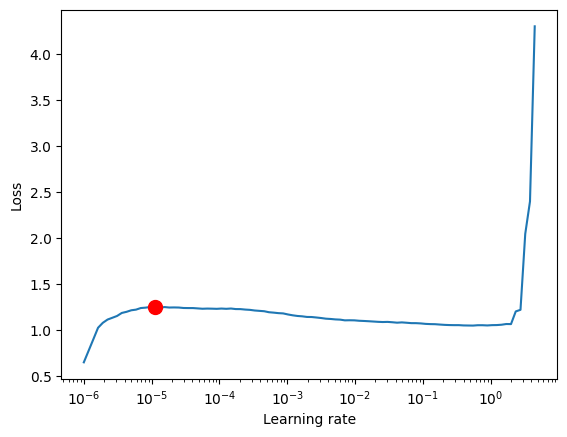

In [37]:
lp.seed_everything(42)
trainer = lp.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    train_ds,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=LR,
    hidden_size=HIDDEN,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=HEADS,
    dropout=DROPOUT,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=HIDDEN // 2,  # set to <= hidden_size
    loss=RMSE(),
    optimizer=torch.optim.Adam,
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")
    
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

## main

In [38]:
lp.seed_everything(42) 

# ========== 8) 训练（按 CV 折） ========== 先取第一折
best_ckpt_paths, fold_metrics = [], []

#for fold_id, (train_days, val_days) in enumerate(folds_by_day, start=1):
####################################
fold_id = 0
train_days, val_days = folds_by_day[fold_id]
####################################

print(f"[fold {fold_id}] train {train_days[0]}..{train_days[-1]} ({len(train_days)} days), "
    f"val {val_days[0]}..{val_days[-1]} ({len(val_days)} days)")

# 明确日期：
train_start_date = int(train_days[0])
train_end_date   = int(train_days[-1])
val_start_date   = int(val_days[0])
val_end_date     = int(val_days[-1])      

# 提取数据
date_range = (train_start_date, val_end_date)
pdf_data = (
    lf_clean
    .filter(pl.col(G_DATE).is_between(train_start_date, val_end_date, closed="both"))
    .collect(streaming=True)
    .to_pandas()
) 

pdf_data[G_SYM] = pdf_data[G_SYM].astype("str")
if "time_bucket" in pdf_data.columns:
    pdf_data["time_bucket"] = pdf_data["time_bucket"].astype("str")
pdf_data.sort_values([G_SYM, "time_idx"], inplace=True)

Seed set to 42


[fold 0] train 1500..1539 (40 days), val 1540..1545 (6 days)


In [39]:

# 明确 indexes:
train_end_idx = pdf_data.loc[pdf_data[G_DATE] == train_end_date, "time_idx"].max()
val_start_idx = pdf_data.loc[pdf_data[G_DATE] == val_start_date, "time_idx"].min()
val_end_idx   = pdf_data.loc[pdf_data[G_DATE] == val_end_date, "time_idx"].max()
assert pd.notna(train_end_idx) and pd.notna(val_start_idx) and pd.notna(val_end_idx), "train/val idx not found"
train_end_idx, val_start_idx, val_end_idx = int(train_end_idx), int(val_start_idx), int(val_end_idx)
print(f"[fold {fold_id}] train idx up to {train_end_idx}, val idx {val_start_idx}..{val_end_idx}")  


[fold 0] train idx up to 38719, val idx 38720..44527


In [40]:
# 构建训练集 timeseries dataset

t_data = pdf_data[TRAIN_COLS]
train_df = t_data.loc[t_data["time_idx"] <= train_end_idx]

train_ds = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target=TARGET_COL,
    group_ids=[G_SYM],
    weight=WEIGHT_COL,
    max_encoder_length=ENC_LEN, min_encoder_length=ENC_LEN,
    max_prediction_length=PRED_LEN, min_prediction_length=PRED_LEN,
    time_varying_known_reals =KNOWN_REALS,
    time_varying_known_categoricals=KNOWN_CATEGORIES,
    static_categoricals=[G_SYM],
    categorical_encoders={G_SYM: NaNLabelEncoder(add_nan=True),
                        "time_bucket": NaNLabelEncoder(add_nan=True) if "time_bucket" in pdf_data.columns else None},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
    target_normalizer=GroupNormalizer(
        method="standard", groups=[G_SYM], center=True, scale_by_group=False),
    scalers=identity_scalers,
)

In [43]:

# 验证集复用 train_ds 的所有 encoders/normalizer（不泄漏）

val_df = t_data.loc[t_data["time_idx"].between(val_start_idx, val_end_idx, inclusive="both")]
val_ds = TimeSeriesDataSet.from_dataset(
    train_ds,
    val_df,
    min_prediction_idx=val_start_idx+ENC_LEN,
    stop_randomization=True,
    predict=False
)

In [44]:
# 数据集加载

train_loader = train_ds.to_dataloader(
    train=True, 
    batch_size=BATCH_SIZE, 
    num_workers=14,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    shuffle=True
)

n_train_batches = len(train_loader)
print(f"[debug] train_loader batches = {n_train_batches}")
assert n_train_batches > 0, "Empty train dataloader. Check min_prediction_idx/ENC_LEN/date windows."

val_loader = val_ds.to_dataloader(
    train=False,
    batch_size=BATCH_SIZE*4,
    num_workers=14,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    shuffle=False,
)

n_val_batches = len(val_loader)
print(f"[debug] val_loader batches = {n_val_batches}")
assert n_val_batches > 0, "Empty val dataloader. Check min_prediction_idx/ENC_LEN/date windows."

[debug] train_loader batches = 2921
[debug] val_loader batches = 106


In [47]:
# 8.6 callbacks/logger/trainer
ckpt_dir_fold = Path(CKPTS_DIR) / f"fold_{fold_id}"
ckpt_dir_fold.mkdir(parents=True, exist_ok=True)

callbacks = [EarlyStopping(monitor="val_loss", mode="min", patience=5, check_on_train_epoch_end=False),
            ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, dirpath=ckpt_dir_fold.as_posix(), filename=f"fold{fold_id}-tft-best-{{epoch:02d}}-{{val_loss:.5f}}", save_on_train_epoch_end=False),
            LearningRateMonitor(logging_interval="step"),]
RUN_NAME = (f"f{fold_id}"f"_E{MAX_EPOCHS}"f"_lr{LR}"f"_bs{BATCH_SIZE}"f"_enc{ENC_LEN}_dec{DEC_LEN}"f"_{datetime.now().strftime('%Y%m%d-%H%M%S')}")
logger = TensorBoardLogger(save_dir=LOGS_DIR.as_posix(),name="tft",version=RUN_NAME,default_hp_metric=False)

trainer = lp.Trainer(max_epochs=3,
                    accelerator="gpu",
                    devices=1,
                    precision="bf16-mixed",
                    enable_model_summary=True,
                    gradient_clip_val=1.0,
                    gradient_clip_algorithm="norm",
                    fast_dev_run=False,
                    limit_train_batches=50,
                    limit_val_batches=25,
                    val_check_interval=0.25,
                    num_sanity_val_steps=2,
                    log_every_n_steps=10,
                    callbacks=callbacks,
                    logger=logger,
                    accumulate_grad_batches=1,
                    )

tft = TemporalFusionTransformer.from_dataset(
    train_ds,
    learning_rate=LR,
    hidden_size=HIDDEN,
    attention_head_size=HEADS,
    dropout=DROPOUT,
    hidden_continuous_size=HIDDEN // 2,
    loss=RMSE(),
    logging_metrics=[RMSE()],
    optimizer=torch.optim.AdamW,
    optimizer_params={"weight_decay": 1e-4},
    reduce_on_plateau_patience=4,
)
trainer.fit(
    tft,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
    )

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 555    | train
3  | prescalers                         | ModuleDict                      | 9.6 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 417 K  | train
6  | decoder_variable_selection         | VariableSelectionN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility

In [ ]:
ckpt_cb = next(cb for cb in callbacks if isinstance(cb, ModelCheckpoint))
best_path = ckpt_cb.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_path)

predictions = best_tft.predict(
    val_loader,
    return_y=True,
    trainer_kwargs=dict(accelerator="gpu")
)
y_pred = predictions.output
y_true, w = predictions.y

In [ ]:
num = (w * (y_true - y_pred).pow(2)).sum()
den = (w * y_true.pow(2)).sum()

wr2 = 1.0 - num / (den + eps)
print(f"wr2 after training: {wr2.item():.6f}")

In [ ]:
val_ds.get_parameters

In [ ]:
num = (torch.square(y_true - y_pred) * w).sum()
den = (torch.square(y_true) * w).sum()  
wr2 = 1 - num / den
print(f"wr2 after training: {wr2}")